<a href="https://colab.research.google.com/github/hooiv/Autoencoders-for-Image-Compression-Denoising-and-Anomaly-Detection/blob/main/Autoencoders%20for%20Image%20Compression%2C%20Denoising%2C%20and%20Anomaly%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
# NO Target requirement for autoencoders (unsupervised learning)
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255. # normalize [0-1]
x_test = x_test.astype('float32') / 255.

In [ ]:
print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


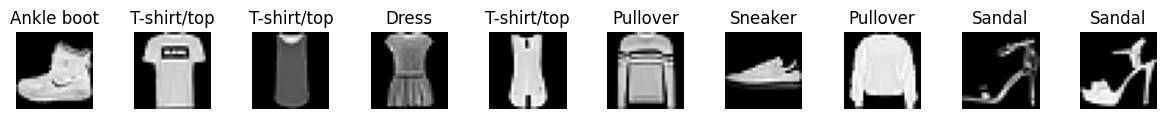

In [ ]:
class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
plt.figure(figsize=(15,1))
for i in range(10):
 plt.subplot(1,10,i+1)
 plt.imshow(x_train[i],cmap='gray')
 plt.title(class_names[y_train[i]])
 plt.axis('off')

In [ ]:
class Autoencoder(Model):
 def __init__(self, latent_dim, shape):
   super(Autoencoder, self).__init__()
   self.latent_dim = latent_dim
   self.shape = shape
   self.encoder = tf.keras.Sequential([
    layers.Flatten(),
    layers.Dense(latent_dim, activation='relu'),
   ])
   self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
])
 def call(self, x):
  encoded = self.encoder(x)
  decoded = self.decoder(encoded)
  return decoded

In [ ]:
shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())


In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.0237 - val_loss: 0.0132
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0116 - val_loss: 0.0105
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.008

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

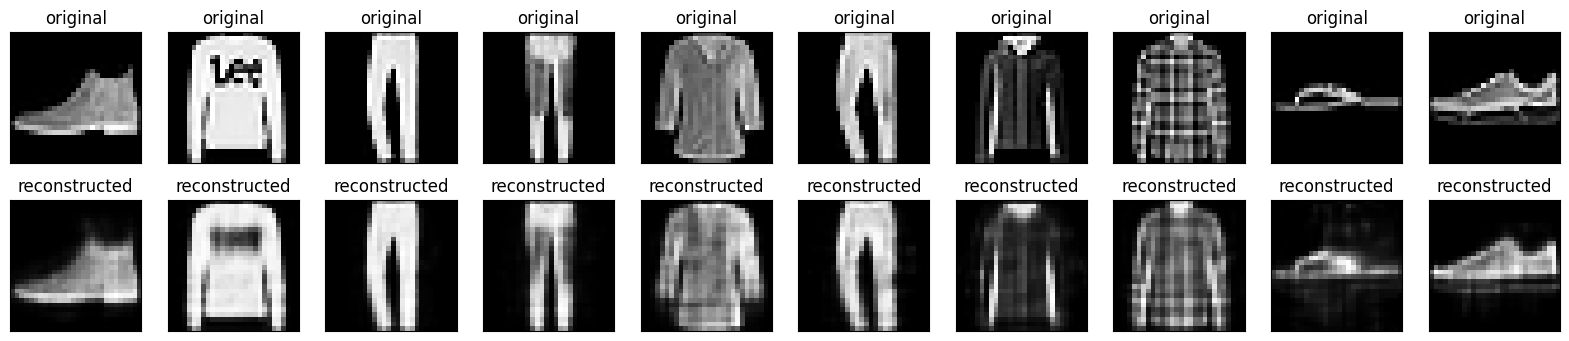

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
 # display original
 ax = plt.subplot(2, n, i + 1)
 plt.imshow(x_test[i])
 plt.title("original")
 plt.gray()
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
 # display reconstruction
 ax = plt.subplot(2, n, i + 1 + n)
 plt.imshow(decoded_imgs[i])
 plt.title("reconstructed")
 plt.gray()
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
############ 2nd example DENOISING
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
print(x_train.shape)

(60000, 28, 28, 1)


In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

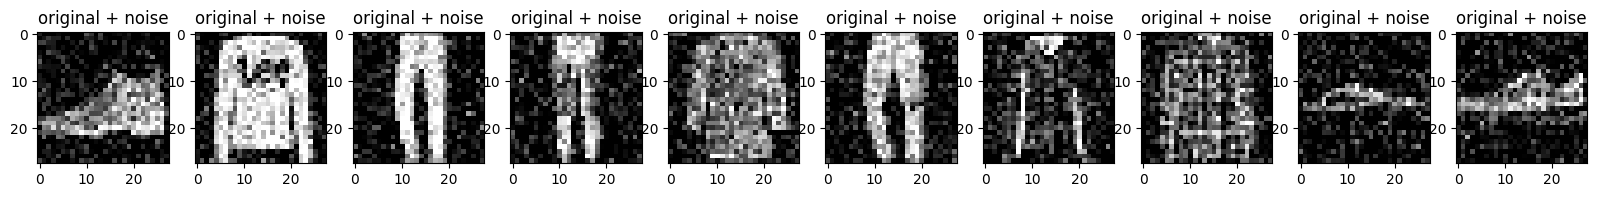

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
 ax = plt.subplot(1, n, i + 1)
 plt.title("original + noise")
 plt.imshow(tf.squeeze(x_test_noisy[i]))
 plt.gray()
plt.show()

In [ ]:
class Denoise(Model):
 def __init__(self):
  super(Denoise, self).__init__()
  self.encoder = tf.keras.Sequential([
   layers.Input(shape=(28, 28, 1)),
   layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
   layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])
  self.decoder = tf.keras.Sequential([
   layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
   layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
   layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])
 def call(self, x):
  encoded = self.encoder(x)
  decoded = self.decoder(encoded)
  return decoded
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train_noisy, x_train,

epochs=10,
shuffle=True,
validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 56s 29ms/step - loss: 0.0180 - val_loss: 0.0092
Epoch 2/10
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 3/10
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 4/10
1875/1875 [==============================] - 59s 32ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 5/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 6/10
1875/1875 [==============================] - 61s 32ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 7/10
1875/1875 [==============================] - 61s 33ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 8/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 9/10
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 10/10
1875/1875 [==============================] - 63s 34m

In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

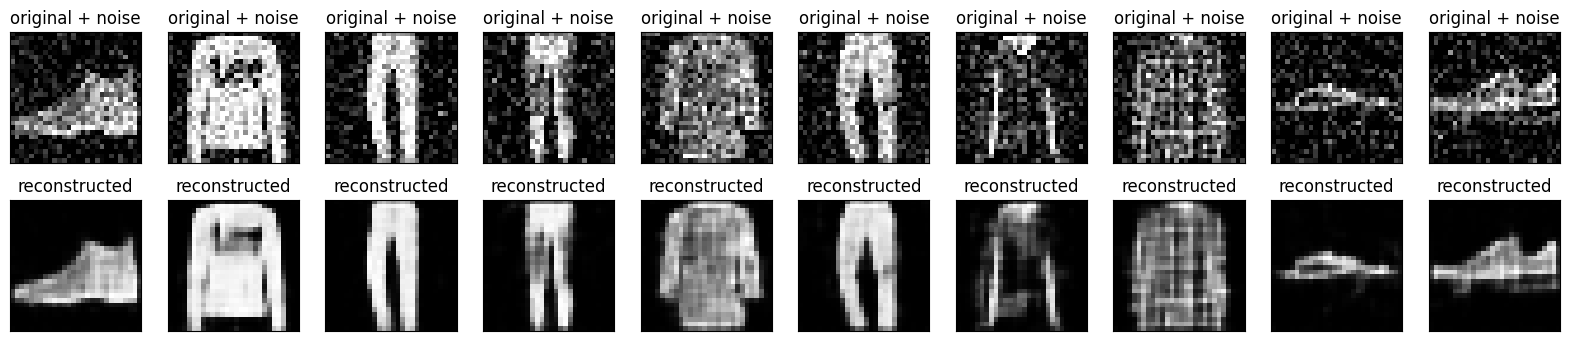

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
 # display original + noise
 ax = plt.subplot(2, n, i + 1)
 plt.title("original + noise")
 plt.imshow(tf.squeeze(x_test_noisy[i]))
 plt.gray()
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
 # display reconstruction
 bx = plt.subplot(2, n, i + n + 1)
 plt.title("reconstructed")
 plt.imshow(tf.squeeze(decoded_imgs[i]))
 plt.gray()
 bx.get_xaxis().set_visible(False)
 bx.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Example 3 Anomaly detection
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [ ]:
dataframe.shape

(4998, 141)

In [ ]:
# The last element contains the labels
labels = raw_data[:, -1]
# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(
data, labels, test_size=0.2, random_state=21
)
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

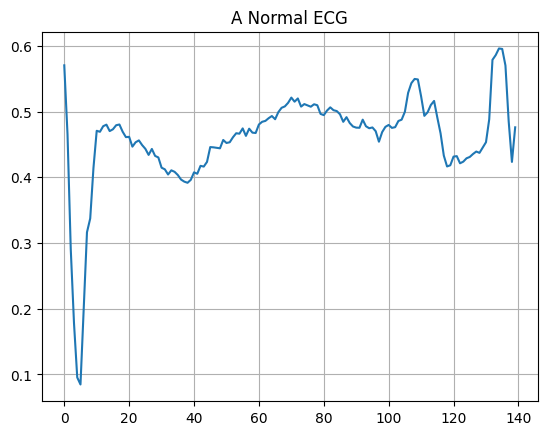

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]
anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

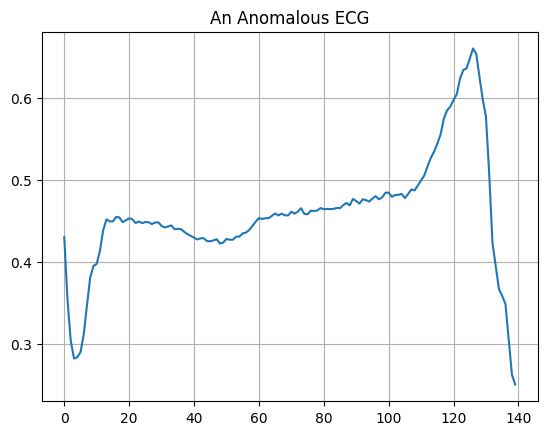

In [ ]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [ ]:
class AnomalyDetector(Model):
 def __init__(self):
   super(AnomalyDetector, self).__init__()
   self.encoder = tf.keras.Sequential([
   layers.Dense(32, activation="relu"),
   layers.Dense(16, activation="relu"),
   layers.Dense(8, activation="relu")])
   self.decoder = tf.keras.Sequential([
   layers.Dense(16, activation="relu"),
   layers.Dense(32, activation="relu"),
   layers.Dense(140, activation="sigmoid")])
 def call(self, x):
   encoded = self.encoder(x)
   decoded = self.decoder(encoded)
   return decoded
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')
history = autoencoder.fit(normal_train_data, normal_train_data,
epochs=20,
batch_size=512,
validation_data=(test_data, test_data),
shuffle=True)

Epoch 1/20
5/5 [==============================] - 2s 51ms/step - loss: 0.0589 - val_loss: 0.0536
Epoch 2/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0566 - val_loss: 0.0524
Epoch 3/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0548 - val_loss: 0.0509
Epoch 4/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0523 - val_loss: 0.0494
Epoch 5/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0490 - val_loss: 0.0482
Epoch 6/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0454 - val_loss: 0.0464
Epoch 7/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0416 - val_loss: 0.0442
Epoch 8/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0381 - val_loss: 0.0428
Epoch 9/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0351 - val_loss: 0.0415
Epoch 10/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0326 - val_loss: 0.0402
Epoch 11/20
5/5 [============

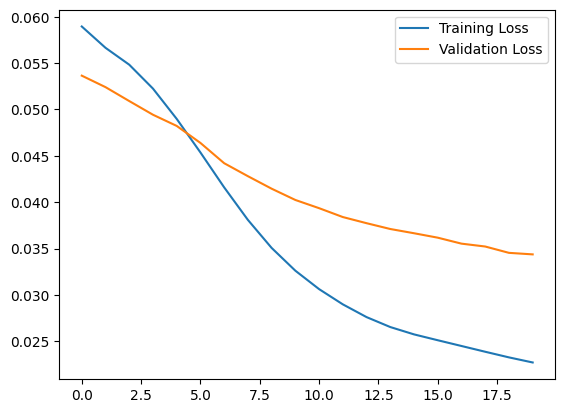

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()